<a href="https://colab.research.google.com/github/seanreed1111/colab-demos/blob/master/btyd_customergen_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

see also: 
- https://www.briancallander.com/posts/customer_lifetime_value/recency_frequency.Rmd
- https://www.briancallander.com/posts/customer_lifetime_value/recency_frequency.html
- https://github.com/mplatzer/BTYDplus/blob/master/R/pareto-nbd-mcmc.R
- https://cran.r-project.org/web/packages/BTYD/BTYD.pdf
- https://github.com/mplatzer/BTYDplus



In [1]:
# installlation required
!pip install -q pyro-ppl=='1.8.0' lifetimes


     |████████████████████████████████| 713 kB 5.3 MB/s 
     |████████████████████████████████| 584 kB 19.0 MB/s 


<a id = "7"></a><br>
# LIBRARIES

In [43]:
import os
import datetime as dt
import pandas as pd
pd.set_option('display.max_rows', 50)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import logging
from scipy.stats import expon, poisson, uniform, lognorm

from numpy.random import Generator, PCG64
numpy_randomGen = Generator(PCG64(seed=1))
from scipy.stats import expon

import torch
from torch.distributions import constraints
from torch import tensor

import pyro
import pyro.distributions as dist

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = [8, 4]


In [3]:
logging.basicConfig(level=logging.WARN)

## Facts about exponentials

In [ ]:
expon.stats(scale=10, moments='mv') #mean and variance calculations
# for scale = x, the rate parameter = lambda = 1/x
# scale = 10periods, rate = 1/10 per period
#The expected value of  expon.rvs(scale=10) = 10

# scale = 5 periods, rate = 1/5 per period
#The expected value of  expon.rvs(scale=5) = 5

# scale = 0.2 periods, rate = 5 per period
#The expected value of  expon.rvs(scale=0.2) = 0.2

# The expectation of expon.rvs(scale=period) := period

(array(10.), array(100.))

In [ ]:
expon.stats(scale=0.1, moments='mv') #mean and variance calculations

(array(0.1), array(0.01))

## Define Helper Functions

In [4]:
import numpy as np
def purchase_sim(*,
                 n = 100,
                 start_period = 0.,
                 holdout_period_end = 100.,
                 forecast_period_end = 120.,
                 mean_customer_lifetime = 80.,
                 mean_period_between_purchases = 10.,
                 var_customer_lifetime = 0.,
                 var_period_between_purchases = 0.
                 ):
    start_dates = np.random.default_rng(1).integers(low=start_period,
                                                    high=holdout_period_end,
                                                    size=n)
    return start_dates

purchase_sim() 

array([47, 51, 75, 95,  3, 14, 82, 94, 24, 31, 86, 42, 27, 82, 25, 40, 64,
       54,  8,  2, 86, 75, 83, 53, 81, 32, 45, 78, 12, 30, 12, 45, 97, 13,
       38, 40, 90, 20, 50, 26,  1, 75,  6, 28, 49, 48, 11, 98, 74, 96,  9,
       72, 29, 54, 92, 27, 72, 16, 32, 96, 42, 51, 29, 11, 42, 62, 45, 77,
       36, 61, 77, 91, 42,  3, 71, 52, 87, 45, 36,  6, 45, 64, 77, 85, 21,
       59, 80, 26, 34, 83, 58, 50, 67, 51, 98, 75,  5, 14, 54, 81])

In [10]:
np.ones_like(purchase_sim())

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [31]:
from scipy.stats import expon

def make_purchases_2(*,
                   id=0,
                   start_period = 10,
                   holdout_period_end = 100.,
                   forecast_period_end = 120.,
                   mean_customer_lifetime = 80.,
                   mean_period_between_purchases = 10.
                   ):


  assert start_period < holdout_period_end and holdout_period_end <= forecast_period_end
  assert mean_customer_lifetime > 0. and mean_period_between_purchases > 0.

  tau = expon.rvs(scale=mean_customer_lifetime) # true (latent) lifetime
  t, k = start_period, 0 
  wait = expon.rvs(scale=mean_period_between_purchases) # waiting time between purchases
  purchase_time= []
  purchase_number = [] #arrays will contain all transactions done by customer

  while ((t + wait) < min(forecast_period_end, start_period + tau)): 
    t += wait
    k += 1
    wait = expon.rvs(scale=mean_period_between_purchases)
    purchase_time.append(t)
    purchase_number.append(k)
  
  return np.stack((id*np.ones(k), np.array(purchase_number), np.array(purchase_time)), axis=1)


In [32]:
p = make_purchases_2()
p


array([[ 0.        ,  1.        , 15.46269465],
       [ 0.        ,  2.        , 18.55783652],
       [ 0.        ,  3.        , 32.11709052],
       [ 0.        ,  4.        , 32.38588245]])

In [75]:
def make_tables(*,
                   n=10,
                   start_period = 0.,
                   forecast_period_end = 120.,
                   mean_customer_lifetime = 80.,
                   mean_period_between_purchases = 10.
                   ):


  assert start_period < forecast_period_end
  assert mean_customer_lifetime > 0. and mean_period_between_purchases > 0.

  transaction_table = np.zeros((1,3))
  rf_table = np.zeros((1,5)) # customer id, date of first transaction, date of last transaction, purchases, date last observed

  for id in range(n):
    tau = expon.rvs(scale=mean_customer_lifetime) # true (latent) lifetime
    t, k = start_period, 0 #can make the start period a random number lt holdout_period
    wait = expon.rvs(scale=mean_period_between_purchases) # waiting time between purchases
    purchase_time= []
    purchase_number = [] #arrays will contain all transactions done by customer

    while ((t + wait) < min(forecast_period_end, start_period + tau)): 
      t += wait
      k += 1
      wait = expon.rvs(scale=mean_period_between_purchases)
      purchase_time.append(t)
      purchase_number.append(k)

    last_transaction_date = t    

    if k==0:
      first_transaction_date = 0
      last_transaction_date = 0
    elif k==1: 
      first_transaction_date = t
    else:
      first_transaction_date = purchase_time[0]
    
    # customer id, date of first transaction, date of last transaction, purchases, date last observed
    rf_table = np.append(rf_table, np.array([id,k,first_transaction_date,last_transaction_date, forecast_period_end]).reshape(-1,5), axis=0)
    transaction_table = np.append(transaction_table, (np.stack((id*np.ones(k), np.array(purchase_number), np.array(purchase_time)), axis=1)), axis=0)

  return transaction_table[1:], rf_table[1:] #ditch the unneeded rows of zeros


In [81]:
_, customers = make_tables()
df = pd.DataFrame(customers, columns=['id','purchases','first_transaction_date','last_transaction_date', 'period_end'])
df.loc[:,'elapsed_time_since_first_purchase'] = df['period_end'] - df['first_transaction_date']
df.loc[:,'elapsed_time_since_last_purchase'] = df['period_end'] - df['last_transaction_date']
df.loc[:,'avg_purchase_rate'] = df['purchases']/df['elapsed_time_since_first_purchase']
df

,id,purchases,first_transaction_date,last_transaction_date,period_end,elapsed_time_since_first_purchase,elapsed_time_since_last_purchase,avg_purchase_rate
0,0.0,5.0,7.181392,43.585439,120.0,112.818608,76.414561,0.044319
1,1.0,13.0,2.906696,109.310265,120.0,117.093304,10.689735,0.111023
2,2.0,6.0,9.269193,116.646059,120.0,110.730807,3.353941,0.054185
3,3.0,2.0,2.040928,5.127091,120.0,117.959072,114.872909,0.016955
4,4.0,14.0,4.299706,103.918187,120.0,115.700294,16.081813,0.121002
5,5.0,4.0,10.388573,19.267333,120.0,109.611427,100.732667,0.036493
6,6.0,6.0,9.897850,39.175160,120.0,110.102150,80.824840,0.054495
7,7.0,4.0,11.367206,25.488154,120.0,108.632794,94.511846,0.036821
8,8.0,6.0,0.760206,23.438256,120.0,119.239794,96.561744,0.050319
9,9.0,1.0,4.389520,4.389520,120.0,115.610480,115.610480,0.008650


In [ ]:
### finish the items below

In [ ]:
data = customers[customers['num_purchases'] >= 2.].copy()
data.describe().T

,count,mean,std,min,25%,50%,75%,max
enrollment_date,5390.0,21.022820,12.824567,0.00,10.00,20.000,32.0000,49.00
num_periods_as_member,5390.0,28.977180,12.824567,1.00,18.00,30.000,40.0000,50.00
num_purchases,5390.0,4.366048,2.471015,2.00,2.00,4.000,6.0000,17.00
tau,5390.0,27.082568,20.262309,0.94,12.97,21.835,35.3875,180.27
num_periods_as_customer,5390.0,11.758891,9.904880,0.00,3.92,9.050,17.2900,48.47
last_purchase_date,5390.0,36.468876,11.922143,0.83,28.08,40.140,46.7575,50.00


In [ ]:
data.head()

,enrollment_date,num_periods_as_member,num_purchases,tau,num_periods_as_customer,last_purchase_date
0,23.0,27.0,7.0,38.64,23.01,47.11
1,25.0,25.0,7.0,27.46,16.32,48.24
4,1.0,49.0,2.0,4.96,1.07,2.89
8,12.0,38.0,5.0,45.55,28.03,43.20
10,43.0,7.0,2.0,3.14,0.81,46.03


In [ ]:
t, T, k = tensor(data['last_purchase_date'].values), tensor(data['num_periods_as_customer'].values), tensor(data['num_purchases'].values)

## Graph Potential Priors

tensor(3.2896e-05) tensor(0.0674) tensor(0.1002) tensor(0.8227) tensor(0.0113)


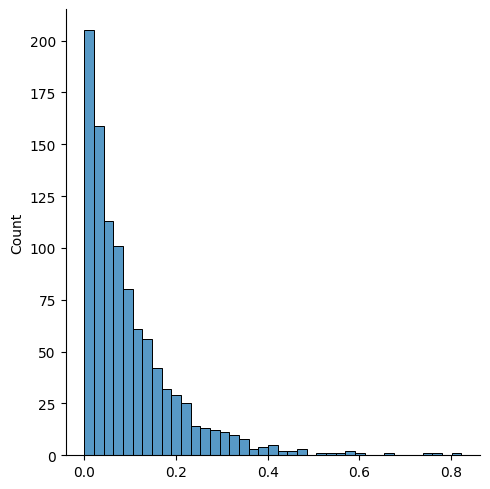

In [ ]:
# Gamma:
# mean = concentration / rate
# var = concentration / rate ^2

data=dist.Gamma(concentration=1, rate=10).expand([1000]).sample()
print(data.min(),  data.median(), data.mean(),data.max(), data.var())
sns.displot(data=data);

tensor(3.4028) tensor(10.4677) tensor(11.6339) tensor(86.2276) tensor(27.7864)


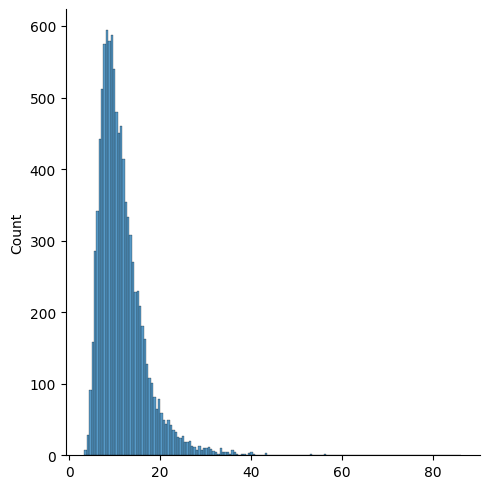

In [ ]:
# Inverse Gamma: for concentration > 2, 
#     mean = rate/(concentration - 1)
#      var ~ concentration^2 / rate ^3
#     MEDIAN  ~ rate / concentration

# Gamma:
# mean = concentration / rate
# var = concentration / rate ^2

data=dist.InverseGamma(concentration=7,rate=70.).expand([10000]).sample()

print(data.min(),  data.median(), data.mean(), data.max(), data.var())
sns.displot(data=data);

tensor(0.0082) tensor(26.3008) tensor(31.2704) tensor(175.4753) tensor(564.3163)


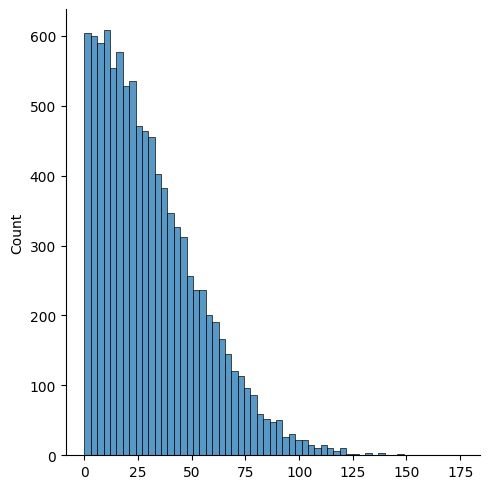

In [ ]:
data=dist.HalfNormal(scale=40).expand([10000]).sample()

print(data.min(),  data.median(), data.mean(), data.max(), data.var())
sns.displot(data=data);

## Model Definition

In [ ]:
# compute priors


http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.687.3554&rep=rep1&type=pdf

**Individual Customer** 

A1. *Poisson purchases*. While active, each customer makes purchases according to a Poisson process with rate λ. 

A2. *Exponential lifetime*. Each customer remains active for a lifetime, which has an exponentially distributed duration with dropout rate μ. 

**Heterogeneity across Customers** 
A3. *Individuals’ purchase rates λ and dropout rates μ follow a multivariate lognormal distribution*. Unlike a Pareto/NBD model, whereby independent gamma distributions are assumed for λ and μ, this assumption permits a correlation between purchase and dropout processes. 

There are several reasons for the lognormal assumption. 
(a) Bayesian updating of a multivariate normal (hence lognormal) is a standard procedure 
and easy to compute. The distribution can readily accommodate additional 
parameters through a hierarchical model, as will be shown in Section 2.3. 
(b) Correlation between log(λ) and log(μ) can be obtained through the 
variance-covariance matrix of the normal mixture distribution.

2.3. **Incorporating Covariates** 
A model that links purchase and dropout rates λ and μ to customer characteristics can offer insights into the profile of customers with frequent transactions and long lifetime.

 

In [ ]:
#original Poisson Model

from torch import nn
from pyro.nn import PyroSample, PyroModule

# need to pass the priors for all models as parameters to the object.
class BayesianPoissonRegression(PyroModule):
    def __init__(self, in_features, out_features = 1, bias = True):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        if bias:
          self.linear.bias = PyroSample(dist.Normal(0., 5.).expand([out_features]).to_event(1))
        self.linear.weight = PyroSample(dist.Normal(0., 0.05).expand([out_features, in_features]).to_event(2))

        
    def forward(self, x, y=None):
        rate = self.linear(x).squeeze(-1).exp() #we are using log link, so apply inverse of log to the matrix multiplication, i.e. exp
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Poisson(rate), obs=y)
        return rate
model = BayesianPoissonRegression(data.size(1)) 
from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel, num_samples=800, warmup_steps=200)

mcmc.run(data, target)


hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}
hmc_samples['linear.weight'].shape
print(f'Median = {np.median(hmc_samples["linear.weight"][:,0,0])}, Mean = {np.mean(hmc_samples["linear.weight"][:,0,0])}')
sns.kdeplot(data=hmc_samples['linear.weight'][:,0,0]);
import arviz as az

az_data = az.from_pyro(mcmc)
az.plot_trace(az_data, compact=False)
plt.tight_layout()


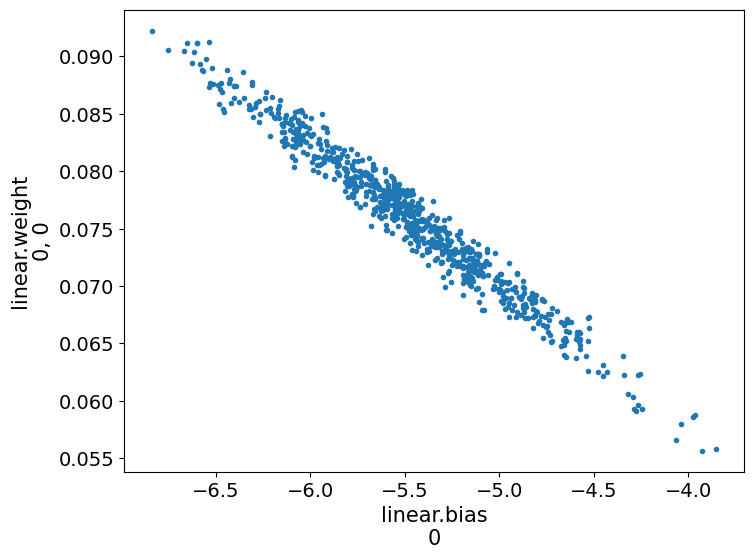

In [ ]:
az.plot_pair(az_data);

In [ ]:
# old model
@AutoReparam(centered=0.)
def model(t, T, k, prior_only=False):
  '''
  input:
  vector t (nx1)  = time since most recent purchase (recency)
  vector T (nx1) = total observation time
  vector k (nx1) = number of purchases observed (k must be >= 2)

  n, etau_alpha, etau_beta, Lambda_alpha, Lambda_beta are scalars
  n = number of customers
  etau_alpha, etau_beta are priors for etau
  Lambda_alpha, Lambda_beta are priors for Lambda
  '''
  assert torch.all(k >=2.), "There are illegal values of k. k must be >= 2"

  def loglik(Lambda, mu, t, T, k):
    target = k * torch.log(Lambda) - torch.log(Lambda + mu)
    n = Lambda.size(0)
    for i in range(n):
      target  = target + torch.logaddexp(torch.log(Lambda[i]) - (Lambda[i] + mu[i]) * T[i],
                                        torch.log(mu[i]) - (Lambda[i] + mu[i]) * t[i]
                                        )
    return target
  
  etau_alpha = pyro.sample('etau_alpha', dist.Uniform(0.95,1.05)) 

  etau_beta = pyro.sample('etau_beta', dist.HalfNormal(scale=40.))
  Lambda_alpha = pyro.sample('Lambda_alpha', dist.Uniform(0.95,1.05))  
  Lambda_beta =pyro.sample('Lambda_beta', dist.HalfNormal(scale=40.))

  if not prior_only:
    with pyro.plate("data", t.size(0)):
      etau  = pyro.sample('etau', dist.InverseGamma(etau_alpha, etau_beta)) #mean customer lifetime
      mu = pyro.deterministic('mu', 1./etau)
      Lambda = pyro.sample('Lambda', dist.Gamma(Lambda_alpha, Lambda_beta)) #lambda = purchase rate
      one_over_Lambda = pyro.deterministic('one_over_Lambda', 1./Lambda)   #days between purchases
    pyro.factor('loglik', loglik(Lambda, mu, t, T, k))

## Prior Only = True

In [ ]:
from pyro.infer import MCMC, NUTS
model = model
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=250)

mcmc.run(t, T, k, prior_only=True)

samples = mcmc.get_samples()
hmc_samples = {k: v.detach().cpu().numpy() for k, v in samples.items()}
hmc_samples.keys()

Sample: 100%|██████████| 1250/1250 [00:28, 43.95it/s, step size=3.56e-01, acc. prob=0.938]


dict_keys(['Lambda_alpha', 'Lambda_beta', 'etau_alpha', 'etau_beta'])

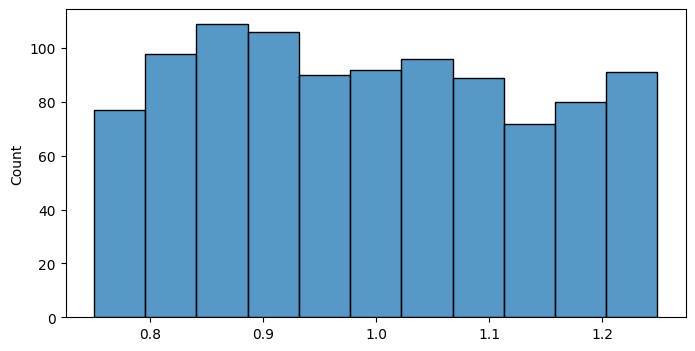

In [ ]:
sns.histplot(data=hmc_samples['Lambda_alpha']);


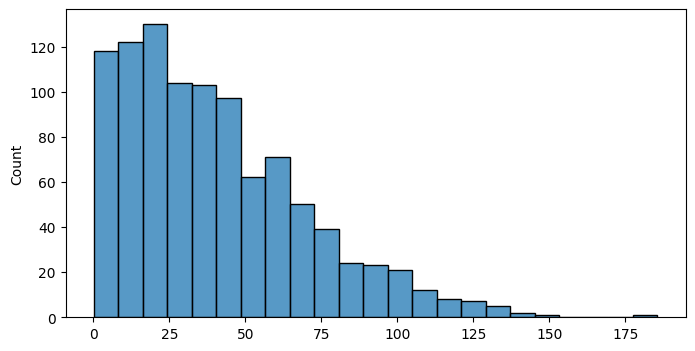

In [ ]:
sns.histplot(data=hmc_samples['Lambda_beta']);

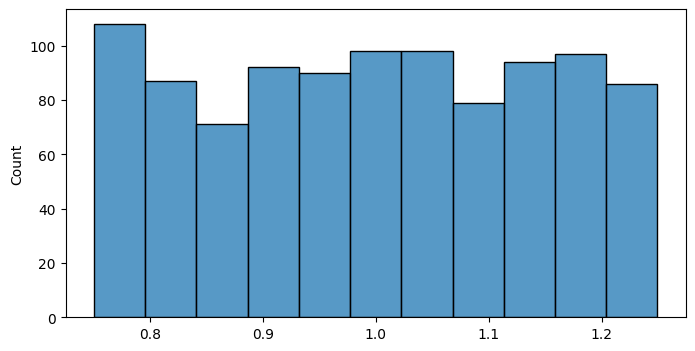

In [ ]:
sns.histplot(data=hmc_samples['etau_alpha']);

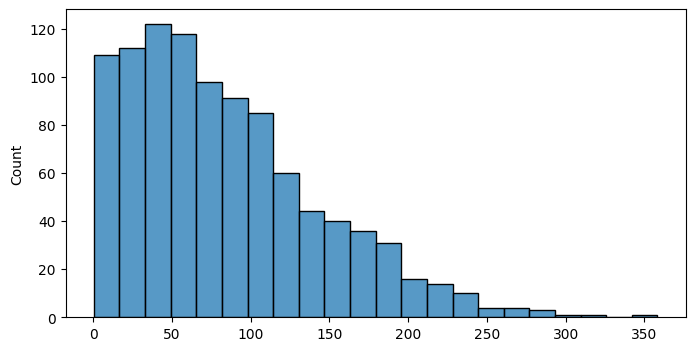

In [ ]:
sns.histplot(data=hmc_samples['etau_beta']);

## Full Model

In [ ]:
model = model
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=3000, warmup_steps=500)

mcmc.run(t, T, k, prior_only=False)

Sample: 100%|██████████| 3500/3500 [28:55,  2.02it/s, step size=1.78e-01, acc. prob=0.918]


In [ ]:
samples = mcmc.get_samples()
hmc_samples = {k: v.detach().cpu().numpy() for k, v in samples.items()}

In [ ]:
hmc_samples.keys()

dict_keys(['Lambda', 'Lambda_alpha', 'Lambda_beta', 'etau_alpha', 'etau_base', 'etau_beta'])

In [ ]:
np.savetxt('etau.gz', hmc_samples['etau_base'], delimiter=',')
np.savetxt('etau_beta.gz', hmc_samples['etau_beta'], delimiter=',')
np.savetxt('etau_alpha.gz', hmc_samples['etau_alpha'], delimiter=',')
np.savetxt('lambda.gz', hmc_samples['Lambda'], delimiter=',')
np.savetxt('lambda_alpha.gz', hmc_samples['Lambda_alpha'], delimiter=',')
np.savetxt('lambda_beta.gz', hmc_samples['Lambda_beta'], delimiter=',')


In [ ]:
# model = model
# nuts_kernel_jit = NUTS(model, jit_compile=True)
# mcmc_jit = MCMC(nuts_kernel_jit, num_samples=5000, warmup_steps=500)

# mcmc_jit.run(t, T, k)
# samples_jit = mcmc_jit.get_samples()
# hmc_samples_jit = {k: v.detach().cpu().numpy() for k, v in samples_jit.items()}

# np.savetxt('etau.gz', hmc_samples_jit['etau_base'], delimiter=',')
# np.savetxt('etau_beta.gz', hmc_samples_jit['etau_beta'], delimiter=',')
# np.savetxt('etau_alpha.gz', hmc_samples_jit['etau_alpha'], delimiter=',')
# np.savetxt('lambda.gz', hmc_samples_jit['Lambda'], delimiter=',')
# np.savetxt('lambda_alpha.gz', hmc_samples_jit['Lambda_alpha'], delimiter=',')
# np.savetxt('lambda_beta.gz', hmc_samples_jit['Lambda_beta'], delimiter=',')


In [ ]:
t, T, k

(tensor([35.1700, 48.5200, 20.1500, 29.0800, 33.0300, 49.6800, 43.9100, 49.4500,
         43.5100, 49.0900, 46.5700, 38.8400, 42.9800, 10.4600, 24.4400, 11.5600,
         40.5800, 48.7300, 30.6800, 26.0300, 31.3500, 28.7300, 41.1800, 18.3300,
         39.8100, 38.2400, 40.8400, 39.6900, 45.6200, 18.9100, 28.9200, 31.3000,
         49.9800, 37.8600, 44.6100, 46.8000, 20.6800, 38.9400, 32.1900, 42.7000,
         28.2700, 34.4800, 44.4700, 44.1900, 20.4000, 42.8000, 49.5200, 47.1800,
         46.2000, 43.9500, 13.5900], dtype=torch.float64),
 tensor([25., 13., 35., 29., 37.,  9., 38., 18.,  7.,  9., 34., 28., 11., 44.,
         28., 44., 31., 25., 50., 36., 26., 45., 14., 36., 23., 37., 14., 29.,
         25., 36., 45., 29., 12., 32., 20.,  5., 49., 15., 28., 32., 47., 28.,
         18.,  8., 40., 21., 37.,  9., 13., 48., 43.], dtype=torch.float64),
 tensor([ 6.,  3.,  2.,  3.,  4.,  5.,  9.,  6.,  2.,  2.,  7.,  7.,  3.,  3.,
          2.,  3.,  4.,  7., 11.,  2.,  3.,  6.,  2.,  4.,  4.

In [ ]:
Lambda = pd.DataFrame(hmc_samples['Lambda']) #lambda = purchase rate
tau = pd.DataFrame(hmc_samples['etau_base']) #lifetime

days_between_purchases_pred = pd.DataFrame(1. /hmc_samples['Lambda'])  #days between purchases
mean_lifetime_pred = pd.DataFrame(1./hmc_samples['etau_base'])

In [ ]:
days_between_purchases_pred.describe().T #days between purchases

,count,mean,std,min,25%,50%,75%,max
0,3000.0,23.933304,3.470989,15.917096,21.426951,23.544739,26.031865,38.947941
1,3000.0,12.959538,1.790931,7.639861,11.678242,12.793941,14.070557,23.375333
2,3000.0,261.329740,224.140787,43.671136,139.999739,199.787704,306.294180,3757.008002
3,3000.0,34.668765,12.025950,18.623397,28.184757,31.934278,37.615146,223.056072
4,3000.0,52.378822,20.167185,25.741573,38.986019,46.717788,59.466941,195.950028
...,...,...,...,...,...,...,...,...
46,3000.0,31.460993,4.150360,20.216484,28.554405,31.150986,33.953593,49.153098
47,3000.0,9.247075,1.245588,6.168219,8.354551,9.141886,10.007604,15.947996
48,3000.0,13.221681,1.835022,8.271138,11.918221,13.065325,14.332914,22.402650
49,3000.0,41.383874,6.288993,26.159493,36.925065,40.649011,45.035168,76.005303


In [ ]:
mean_lifetime_pred.describe().T

,count,mean,std,min,25%,50%,75%,max
0,3000.0,22978.518173,9.160435e+05,62.344144,475.787534,1008.010851,2448.146326,5.010852e+07
1,3000.0,5967.119013,3.134466e+04,84.545778,536.237399,1053.177438,2853.061187,8.607637e+05
2,3000.0,24.567984,4.223253e+00,14.616693,21.581572,24.017671,26.847656,5.223666e+01
3,3000.0,1620.246727,1.353919e+04,28.793811,125.799175,240.063502,600.668830,5.260093e+05
4,3000.0,622.780854,9.182490e+03,32.617045,76.949364,128.124618,259.820547,4.512245e+05
...,...,...,...,...,...,...,...,...
46,3000.0,60498.705393,1.653304e+06,84.892500,728.306139,1413.365105,3581.339573,7.910871e+07
47,3000.0,4062.505038,1.793926e+04,61.841087,405.458672,816.008901,2172.926544,4.651188e+05
48,3000.0,5435.886590,4.877406e+04,80.376658,513.141427,1047.716972,2669.669797,2.229446e+06
49,3000.0,6056.786332,1.257971e+05,75.523152,321.027909,624.672921,1540.424100,6.464060e+06


In [ ]:
tau.describe().T

,count,mean,std,min,25%,50%,75%,max
0,3000.0,0.001510,0.001569,1.995668e-08,0.000408,0.000992,0.002102,0.016040
1,3000.0,0.001380,0.001450,1.161759e-06,0.000351,0.000950,0.001865,0.011828
2,3000.0,0.041828,0.006759,1.914364e-02,0.037247,0.041636,0.046336,0.068415
3,3000.0,0.005594,0.005136,1.901107e-06,0.001665,0.004166,0.007949,0.034730
4,3000.0,0.008870,0.006111,2.216192e-06,0.003849,0.007805,0.012996,0.030659
...,...,...,...,...,...,...,...,...
46,3000.0,0.000995,0.001010,1.264083e-08,0.000279,0.000708,0.001373,0.011780
47,3000.0,0.001795,0.001848,2.149988e-06,0.000460,0.001225,0.002466,0.016170
48,3000.0,0.001397,0.001410,4.485419e-07,0.000375,0.000954,0.001949,0.012441
49,3000.0,0.002158,0.002013,1.547015e-07,0.000649,0.001601,0.003115,0.013241


In [ ]:
compare = data.reset_index()

In [ ]:
pd.set_option('display.max_rows', 40)

In [ ]:
pd.concat([compare['tau'],mu.describe().T ], axis=1)

,tau,count,mean,std,min,25%,50%,75%,max
0,13.40,500.0,32.272525,13.502087,14.590903,23.776609,28.921601,36.831932,151.618750
1,63.41,500.0,23.821175,6.087585,13.415673,19.366960,22.976885,27.160087,51.839041
2,11.49,500.0,12.895071,3.253164,6.392016,10.554043,12.355718,14.467547,27.833931
3,11.03,500.0,3.807762,0.986935,1.872371,3.066081,3.628595,4.332071,7.781647
4,22.54,500.0,37.062169,13.898138,14.227668,27.932496,34.377374,42.622237,103.399370
...,...,...,...,...,...,...,...,...,...
46,42.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,9.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,10.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,65.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pd.concat([compare['purchases']/compare['T_observed'],one_over_lambda.describe().T ], axis=1)

,index,enrollment_date,T_observed,purchases,tau,date_of_last_purchase,mean_customer_lifetime,1/mean_customer_lifetime,count,mean,std,min,25%,50%,75%,max
0,0,23.0,27.0,2.0,3.79,24.96,20.0,0.05,500.0,0.034884,0.010889,0.006595,0.027150,0.034576,0.042058,0.068536
1,1,25.0,25.0,3.0,19.16,42.59,20.0,0.05,500.0,0.044597,0.010777,0.019290,0.036819,0.043522,0.051634,0.074540
2,2,37.0,13.0,3.0,9.11,41.73,20.0,0.05,500.0,0.082132,0.019249,0.035927,0.069121,0.080934,0.094750,0.156445
3,3,47.0,3.0,3.0,5.59,48.39,20.0,0.05,500.0,0.279695,0.069779,0.128507,0.230837,0.275589,0.326149,0.534082
4,4,1.0,49.0,7.0,15.52,15.48,20.0,0.05,500.0,0.030338,0.010136,0.009671,0.023462,0.029089,0.035801,0.070286
5,5,7.0,43.0,9.0,36.17,41.71,20.0,0.05,500.0,0.034873,0.007156,0.018849,0.029341,0.034480,0.039338,0.059051
6,9,15.0,35.0,4.0,51.61,39.20,20.0,0.05,500.0,0.032868,0.008380,0.014330,0.026807,0.032283,0.037525,0.066254
7,11,21.0,29.0,4.0,36.54,49.41,20.0,0.05,500.0,0.040973,0.010243,0.013372,0.033790,0.040615,0.047739,0.075349
8,12,13.0,37.0,3.0,24.17,32.77,20.0,0.05,500.0,0.026762,0.007787,0.008459,0.021689,0.025997,0.031913,0.051631
9,14,12.0,38.0,10.0,28.90,38.40,20.0,0.05,500.0,0.041646,0.008527,0.020168,0.035193,0.040913,0.047464,0.072037


In [ ]:
pd.concat([data.reset_index(), mu.describe().T ], axis=1)

,index,enrollment_date,T_observed,purchases,tau,date_of_last_purchase,mean_customer_lifetime,1/mean_customer_lifetime,count,mean,std,min,25%,50%,75%,max
0,1,51.0,49.0,4.0,28.58,69.98,60.0,0.02,1000.0,49.108642,6.832279,32.697287,44.506575,48.402653,53.229448,72.286738
1,2,75.0,25.0,2.0,121.17,99.92,60.0,0.02,1000.0,25.523177,3.334071,16.484570,23.044953,25.268921,27.671613,39.422032
2,4,3.0,97.0,4.0,62.70,62.60,60.0,0.02,1000.0,358.186724,171.138614,116.286510,244.969165,313.612022,423.775276,1426.764425
3,5,14.0,86.0,2.0,22.77,25.60,60.0,0.02,1000.0,628.463520,495.762367,126.130771,325.218776,486.064950,730.066529,4505.821329
4,8,24.0,76.0,3.0,28.51,46.24,60.0,0.02,1000.0,391.121545,263.877190,77.463478,232.423972,323.636815,460.090725,2877.523038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,89,83.0,17.0,3.0,21.68,96.85,60.0,0.02,1000.0,17.340172,2.314698,12.266276,15.673964,17.023464,18.865211,27.250274
51,92,67.0,33.0,2.0,274.79,96.45,60.0,0.02,1000.0,33.742928,5.081470,20.625620,30.198926,33.163330,36.667441,56.688995
52,93,51.0,49.0,5.0,26.94,67.24,60.0,0.02,1000.0,47.728380,6.678595,32.462764,43.166139,46.855318,51.356781,78.388800
53,96,5.0,95.0,2.0,25.44,23.45,60.0,0.02,1000.0,605.634731,549.581941,104.539754,319.036137,455.998934,692.846443,5731.576242


## Centered BTYD

In [ ]:

# https://www.briancallander.com/posts/customer_lifetime_value/models/rf.stan
# data_hyperpriors <- list(
#   log_life_mean_mu = log(31),
#   log_life_mean_sigma = 0.7,
#   log_life_scale_sigma = 0.8,

#   log_lambda_mean_mu = log(1 / 14),
#   log_lambda_mean_sigma = 0.3,
#   log_lambda_scale_sigma = 0.5
# )
data {
  int<lower = 1> n;       // number of customers
  vector<lower = 0>[n] t; // time to most recent purchase
  vector<lower = 0>[n] T; // total observation time
  vector<lower = 0>[n] k; // number of purchases observed

  // user-specified parameters
  real<lower = 0> etau_mean_alpha;
  real<lower = 0> etau_mean_beta;
  real<lower = 0> etau_sd_alpha;
  real<lower = 0> etau_sd_beta;

  real<lower = 0> lambda_mean_alpha;
  real<lower = 0> lambda_mean_beta;
  real<lower = 0> lambda_sd_alpha;
  real<lower = 0> lambda_sd_beta;
}

parameters {
  vector<lower = 0>[n] lambda; // purchase rate
  vector<lower = 0>[n] etau;   // expected mean lifetime

  vector<lower = 0>[n] etau_mean; // mean expected life span
  vector<lower = 0>[n] etau_sd;
  vector<lower = 0>[n] lambda_mean; // mean purchase rate
  vector<lower = 0>[n] lambda_sd;

}

transformed parameters {
  vector<lower = 0>[n] etau_beta = etau_mean;
  vector<lower = 0>[n] etau_alpha = etau_sd;
  vector<lower = 0>[n] lambda_beta = lambda_mean ./ (lambda_sd .* lambda_sd);
  vector<lower = 0>[n] lambda_alpha = lambda_beta .* lambda_mean;

  vector<lower = 0>[n] mu = 1.0 ./ etau;
}

model {
  // hyperpriors
  etau_mean ~ gamma(etau_mean_alpha, etau_mean_beta);
  etau_sd ~ gamma(etau_sd_alpha, etau_sd_beta);

  lambda_mean ~ gamma(lambda_mean_alpha, lambda_mean_beta);
  lambda_sd ~ gamma(lambda_sd_alpha, lambda_sd_beta);

  // priors
  etau ~ inv_gamma(etau_alpha, etau_beta);
  lambda ~ gamma(lambda_alpha, lambda_beta);

  // likelihood
  target += k .* log(lambda) - log(lambda + mu);
  for (i in 1:n) {
    target += log_sum_exp(
      log(lambda[i]) - (lambda[i] + mu[i]) .* T[i],
      log(mu[i]) - (lambda[i] + mu[i]) .* t[i]
    );
  }
}
